In [1]:
# %pip install gensim
# %pip install -q -U keras-tuner

import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim.corpora import Dictionary

from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE           
import random
import multiprocessing
import unittest
from scipy import spatial

from dma_functions import get_dma, get_dma_zipcodes
import keras_tuner as kt

WORKERS = multiprocessing.cpu_count() - 1

READ IN TRAINING DATA

In [3]:
# Agent Sentence data
agent_data = pd.read_csv("s3://ojo-data-science/scratch/kentcz/eli-dataset/realtor_agent_zipcodes.csv",
                        converters={'zipcodes': lambda x: x[1:-1].replace("'", "").replace(" ", "").split(',')})

agent_data["length"] = agent_data["zipcodes"].apply(lambda x: len(x))
agent_data = agent_data[agent_data["length"] >= 2]

agent_sentences = agent_data["zipcodes"].tolist()

In [4]:
# Agent zipcode preference data
agent_preferences = pd.read_csv("s3://ojo-data-science/scratch/kentcz/eli-dataset/realtor_agent_zipcode_prefernces.csv",
                                usecols=["dma_from_agent", "zipcode_array", "zipcodes_length"],
                        converters={'zipcode_array': lambda x: x[1:-1].replace("'", "").replace(" ", "").split(',')})
agent_preferences = agent_preferences[agent_preferences["zipcodes_length"] >= 2]

agent_preferences_sentences = agent_preferences["zipcode_array"].tolist()

In [5]:
# Get clickstream_v2_sentences
clickstream_v2 = pd.read_csv("./data/training_data/clickstream_v2_augmented.csv",
                             usecols=["unique_visit_id", "sentences", "length"],
                            converters={'sentences': lambda x: x[1:-1].replace("'", "").replace(" ", "").split(',')})

# First clean: only keep sessions that are geq 2 in length
clickstream_v2 = clickstream_v2[clickstream_v2["length"] >= 2]
# Second clean: only keep sessions that are leq 9 in length (those greater are "unfocused users")
clickstream_v2 = clickstream_v2[clickstream_v2["length"] <= 9]
clickstream_v2_sentences_list = clickstream_v2["sentences"].to_list()
# Replace all occurrences of "69708" with "96708"
cleaned_sentences = []
for sentence in clickstream_v2_sentences_list:
    if "69708" not in sentence:
        cleaned_sentences.append(sentence)
    else:
        cleaned = [zipcode.replace("69708", "96708") for zipcode in sentence]
        cleaned_sentences.append(cleaned)
clickstream_v2_sentences = cleaned_sentences

In [6]:
# Get clickstream_v2_sentences split by DMA
clickstream_v2_dma = pd.read_csv("./data/training_data/clickstream_v2_dma.csv",
                                 usecols=["unique_visit_id", "sentences", "length", "sentences_dma"],
                                converters={"sentences": lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','),
                                            'sentences_dma': lambda x: x[1:-1].replace("'", "").replace(" ", "").split(',')})
clickstream_v2_dma["dma_sentence_length"] = clickstream_v2_dma["sentences_dma"].apply(lambda x: len(x))
clickstream_v2_dma = clickstream_v2_dma[clickstream_v2_dma["dma_sentence_length"] >= 2]
clickstream_v2_dma = clickstream_v2_dma[clickstream_v2_dma["length"] <= 9]
clickstream_v2_dma_sentences = clickstream_v2_dma["sentences_dma"].to_list()
# Replace all occurrences of "69708" with "96708"
cleaned_sentences = []
for sentence in clickstream_v2_dma_sentences:
    if "69708" not in sentence:
        cleaned_sentences.append(sentence)
    else:
        cleaned = [zipcode.replace("69708", "96708") for zipcode in sentence]
        cleaned_sentences.append(cleaned)
clickstream_v2_dma_sentences = cleaned_sentences

BUILD MODEL

In [7]:
# Gensim implementation
class callback(CallbackAny2Vec):
    # Callback to print loss after each epoch

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

VECTOR_SIZE = 50
SENTENCES = clickstream_v2_sentences

# Model architecture and training
model_w2v = Word2Vec(
    SENTENCES,
    vector_size=VECTOR_SIZE,
    sg=1,
    window=6,
    negative=8,
    min_count=2,
    workers=WORKERS,
    callbacks=[callback()],
    epochs=6,
    compute_loss=True,
    seed=1
)

Loss after epoch 0: 6479835.0
Loss after epoch 1: 2559197.0
Loss after epoch 2: 2282806.0
Loss after epoch 3: 2270314.0
Loss after epoch 4: 2231533.0
Loss after epoch 5: 2044343.0


In [8]:
# model_w2v.save("agent_sentences.model")
# model_w2v.save("clickstream_v2_50.model")
# model_w2v.save("clickstream_v2_40.model")
# model_w2v.save("clickstream_v2_dma_50.model")

In [9]:
# model_w2v = Word2Vec.load("./models/agent_sentences.model")
# VECTOR_SIZE = 40
# SENTENCES = agent_sentences

# model_w2v = Word2Vec.load("./models/clickstream_v2_50.model")
# VECTOR_SIZE = 50
# SENTENCES = clickstream_v2_sentences

# model_w2v = Word2Vec.load("./models/clickstream_v2_40.model")
# VECTOR_SIZE = 40
# SENTENCES = clickstream_v2_sentences

# model_w2v = Word2Vec.load("./models/clickstream_v2_dma_50.model")
# VECTOR_SIZE = 50
# SENTENCES = clickstream_v2_dma_sentences

READ IN AND PREPARE EVALUATION DATA

In [2]:
realtor_df_hotness = pd.read_csv(
    "./data/evaluation_data/hotness_metrics.csv",
    dtype={"postal_code": str, "month_date_yyyymm": str}
)

# Only use most recent data (ie from 202206)
realtor_df_hotness = realtor_df_hotness[realtor_df_hotness["month_date_yyyymm"] == "202206"]

# Clean data
columns_missing = realtor_df_hotness.isnull().sum()[realtor_df_hotness.isnull().sum() > 0].index.tolist()
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Create new dataframe to hold columns with imputed values
clean_columns_missing = pd.DataFrame(imputer.fit_transform(realtor_df_hotness[columns_missing]))

# Iterate through columns that had missing values and swap them for new dataframe's columns
for index, column in enumerate(columns_missing):
    realtor_df_hotness[column] = clean_columns_missing[index]
    
# Clean DataFrame so that 4 digit zips become 5 digit (EG 2459 -> 02459)
def convert_four_digit_zip(zipcode):
    # If zip is longer than 4 digits, return same zipcode
    if len(zipcode) > 4:
        return zipcode
    elif len(zipcode) == 4:
        return "0" + zipcode
    else:
        raise Exception('Invalid zipcode/zipcode length')
        
realtor_df_hotness["postal_code"] = realtor_df_hotness["postal_code"].apply(convert_four_digit_zip)

In [3]:
# Read in core metrics data
realtor_df_core = pd.read_csv("./data/evaluation_data/core_metrics_june.csv",
                              usecols= ['month_date_yyyymm', 'postal_code', 'zip_name', 'median_listing_price',
                                       'active_listing_count',  'median_days_on_market', 'new_listing_count',
                                       'price_increased_count', 'price_reduced_count', 'pending_listing_count', 
                                        'median_listing_price_per_square_foot', 'median_square_feet',
                                       'average_listing_price','total_listing_count', 'pending_ratio'],
                            dtype={"postal_code": str, "month_date_yyyymm": str})
realtor_df_core = realtor_df_core[realtor_df_core["month_date_yyyymm"] == "202206"]
realtor_df_core["postal_code"] = realtor_df_core["postal_code"].apply(convert_four_digit_zip)

# Add "demand_score, supply_score, hotness_score" as a column to realtor_df_core
metrics = ["demand_score", "supply_score", "hotness_score"]
for metric in metrics:
    hotness_metrics = dict()
    for _, row in realtor_df_hotness.iterrows():
        hotness_metrics[row["postal_code"]] = row[metric]

    data_metrics = []
    for _, row in realtor_df_core.iterrows():
        if row["postal_code"] in hotness_metrics:
            data_metrics.append(hotness_metrics[row["postal_code"]])
        else:
            data_metrics.append(None)
    realtor_df_core[metric] = data_metrics
    
# Only use "high-quality" data points AKA total_listing_count >= 40
realtor_df_core = realtor_df_core[realtor_df_core["total_listing_count"] >= 40]

realtor_df = realtor_df_core.copy()

In [4]:
# Equality of arrays
def is_equal(list_1, list_2):
    return sorted(list_1) == sorted(list_2)

# Get target
TARGET = 'median_listing_price_per_square_foot'

In [5]:
# Get previous data for missing data from target
historical_df = pd.read_csv("./data/evaluation_data/core_metrics_history.csv",
                                dtype={"postal_code": str, "month_date_yyyymm": str})

# Check to make sure historical_df has TARGET's values
if TARGET in historical_df.columns:
    filled_values = dict()

    missing_data = realtor_df[realtor_df[TARGET].isnull()]
    for _, row in missing_data.iterrows():
        cut = historical_df[historical_df["postal_code"] == row["postal_code"]]
        cut_values = cut.sort_values("month_date_yyyymm", ascending=False)[TARGET].values
        for value in cut_values:
            if np.isnan(value):
                continue
            else:
                filled_values[row["postal_code"]] = value
                break

    # Impute it back in realtor.com data
    imputed_values = []
    for _, row in realtor_df.iterrows():
        current_value = row[TARGET]
        if np.isnan(current_value):
            # Check if filled_values has data for this zipcode
            if row["postal_code"] in filled_values:
                imputed_values.append(filled_values[row["postal_code"]])
            else:
                imputed_values.append(None)
        else: 
            imputed_values.append(current_value)
    realtor_df[TARGET] = imputed_values

# Remove None values for TARGET
realtor_df = realtor_df[realtor_df[TARGET].notnull()]

GENERATE EMBEDDINGS USING WORD2VEC

In [17]:
# Converts zipcode str to embedding
def zip_to_embedding(zipcode):
    # Some zips may not be in the corpus of the w2v model
    try:
        zip_embedding = model_w2v.wv[zipcode]
    except KeyError:
        zip_embedding = None
    return zip_embedding

In [18]:
realtor_df_copy = realtor_df.copy()

# Add embedding column
realtor_df_copy["zip_embedding"] = realtor_df_copy["postal_code"].apply(zip_to_embedding)

# Remove None values for zip_embedding
realtor_df_copy = realtor_df_copy[realtor_df_copy["zip_embedding"].notnull()]

BEGIN MODELLING FOR EVALUATION

In [19]:
# Assign random VECTOR_SIZE-dimensional vectors for baseline embeddings
X_baseline = realtor_df_copy["zip_embedding"].apply(lambda x: np.random.rand(VECTOR_SIZE))
y_baseline = realtor_df_copy[TARGET]

# True model inputs and labels
X = realtor_df_copy["zip_embedding"]
y = realtor_df_copy[TARGET]

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 200

In [20]:
# Function to convert Series of embeddings to array of tensors
def embeddings_to_tensors(df):
    tensors_array = []
    if type(df) == pd.core.series.Series:
        for embedding in df.values:
            tensors_array.append(tf.convert_to_tensor(embedding))
    elif type(df) == np.ndarray:
        for embedding in df:
            tensors_array.append(tf.convert_to_tensor(embedding))
    else: 
        print("bad type for embeddings_to_tensors")
        return None
    return tensors_array

def data_to_datasets(x_train, y_train, x_test, y_test, x_val, y_val):
    # Convert embeddings -> tensors -> dataset
    x_train_tensors = embeddings_to_tensors(x_train)
    y_train_tensors = embeddings_to_tensors(y_train)
    x_test_tensors = embeddings_to_tensors(x_test)
    y_test_tensors = embeddings_to_tensors(y_test)
    x_val_tensors = embeddings_to_tensors(x_val)
    y_val_tensors = embeddings_to_tensors(y_val)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_tensors, y_train_tensors))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tensors, y_test_tensors))
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_tensors, y_val_tensors))
    
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    
    return train_dataset, test_dataset, val_dataset

In [21]:
# Model architecture and compiling
model = keras.Sequential()
model_baseline = keras.Sequential()
neural_nets = [model, model_baseline]
for model in neural_nets:
    model.add(BatchNormalization(input_shape=[VECTOR_SIZE]))
    model.add(Dense(336, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(496, activation="relu"))
    model.add(Dense(368, activation="relu"))
    model.add(Dense(176, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
        loss="mae",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

# Implement early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience = 8,
    verbose=1,
    restore_best_weights=True
)

In [47]:
# Implement KFold CV
def run_KFold(model, x, y):
    kf = KFold(5, shuffle=True)
    test_losses = []
    for train_indices, test_indices in kf.split(x):
        x_train, x_test = x.values[train_indices], x.values[test_indices]
        y_train, y_test = y.values[train_indices], y.values[test_indices]
        # Further split training set -> train + validation
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, test_size=0.2)

        # Convert embeddings -> tensors -> dataset
        train_ds, test_ds, val_ds = data_to_datasets(x_train, y_train, x_test, y_test, x_val, y_val)

        model.fit(train_ds, 
                  validation_data=val_ds,
                  epochs=EPOCHS, 
                  callbacks=[early_stopping], 
                  workers=WORKERS)
        mae_loss, _ = model.evaluate(test_ds)
        print("Test loss: " + str(mae_loss))
        test_losses.append(mae_loss)
    return np.mean(test_losses)

NUMBER_PREDICTIONS = 30
def get_predictions(model, test):
    predictions = []
    for counter, embedding in enumerate(test):
        embedding = embedding.reshape(-1, VECTOR_SIZE)
        predictions.append(model.predict(embedding))
    return predictions

def get_model_predictions(model, test_x):
    # Get predictions for test_x
    print("Getting predictions...")
    y_pred = get_predictions(model, test_x[:NUMBER_PREDICTIONS])
    
    # Get zipcodes of test_x
    print("Getting zipcodes...")
    zipcodes = []
    for counter, test_embedding in enumerate(test_x):
        if counter >= NUMBER_PREDICTIONS:
            break
        else:
            for index, embedding in enumerate(realtor_df_copy.zip_embedding.values):
                if is_equal(embedding, test_embedding):
                    zipcodes.append(realtor_df_copy.iloc[index].postal_code)
    return y_pred, zipcodes
                    
def plot_evaluate(zipcodes, pred_y, test_y):
    predicted_value = np.reshape(pred_y, -1)
    actual_value = test_y.values[:NUMBER_PREDICTIONS]
    
    # Plot of predicted vs actual score for test set
    plt.figure(figsize=(30, 8))
    plt.title(TARGET + " vs zipcodes")
    sns.lineplot(x=zipcodes, y=predicted_value[:NUMBER_PREDICTIONS], label="predicted " + TARGET)
    sns.lineplot(x=zipcodes, y=actual_value[:NUMBER_PREDICTIONS], label="actual " + TARGET)
    plt.xlabel("Zipcodes")
    plt.ylabel(TARGET)
    plt.show()

    # Plot XY plot of predicted vs actual score for test set
    plt.figure(figsize=(12, 12))
    plt.title("Predicted " + TARGET + " vs actual " + TARGET)
    sns.regplot(x=actual_value, y=predicted_value)
    plt.xlabel("Actual " + TARGET)
    plt.ylabel("Predicted " + TARGET)
    plt.axis("square")    
    plt.show()
    
def get_worst_zipcodes(model, df):
    # Get predictions for all zipcodes
    embeddings = df['zip_embedding'].values
    predictions = []
    print("Getting all predictions for this dataframe...")
    for embedding in embeddings:
        embedding = embedding.reshape(-1, VECTOR_SIZE)
        predictions.append(model.predict(embedding)[0][0])
    error_df = pd.DataFrame({"zipcodes": df["postal_code"], 
                             "predictions": predictions, 
                             "actual": df[TARGET]})
    error_df["error"] = np.abs(error_df["actual"] - error_df["predictions"])
    return error_df.sort_values("error", ascending=False, ignore_index=True)

In [44]:
# Baseline performance
# run_KFold(model_baseline, X_baseline, y_baseline)

In [24]:
# Run KFold to get most accurate evaluation
run_KFold(model, X, y)

Epoch 1/200
171/171 [==============================] - 2s 11ms/step - loss: 96.7067 - root_mean_squared_error: 174.0640 - val_loss: 102.7090 - val_root_mean_squared_error: 165.1343
Epoch 2/200
171/171 [==============================] - 1s 7ms/step - loss: 75.7109 - root_mean_squared_error: 136.7223 - val_loss: 70.4182 - val_root_mean_squared_error: 110.2213
Epoch 3/200
171/171 [==============================] - 1s 5ms/step - loss: 70.4694 - root_mean_squared_error: 129.0372 - val_loss: 58.5424 - val_root_mean_squared_error: 105.1859
Epoch 4/200
171/171 [==============================] - 1s 5ms/step - loss: 68.2394 - root_mean_squared_error: 122.2759 - val_loss: 59.7724 - val_root_mean_squared_error: 104.6047
Epoch 5/200
171/171 [==============================] - 1s 5ms/step - loss: 63.6742 - root_mean_squared_error: 118.0671 - val_loss: 55.0705 - val_root_mean_squared_error: 96.6756
Epoch 6/200
171/171 [==============================] - 1s 5ms/step - loss: 62.8164 - root_mean_squared_e

40.34195404052734

Getting predictions...
Getting zipcodes...


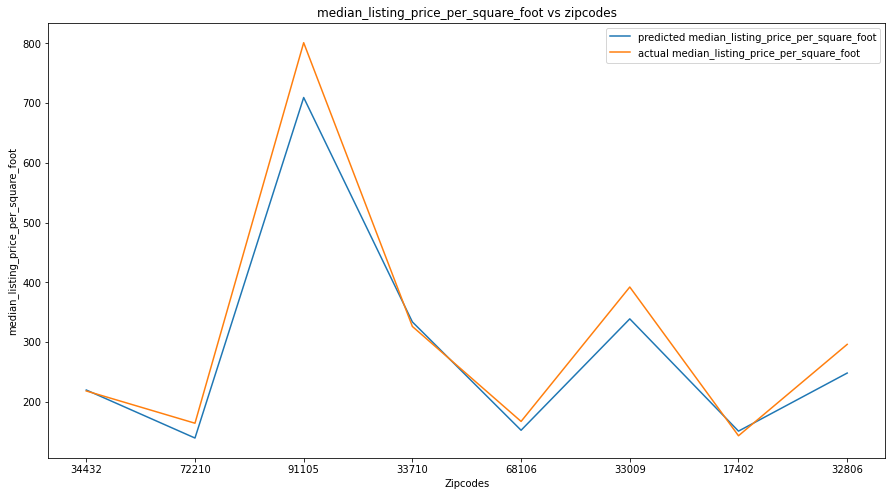

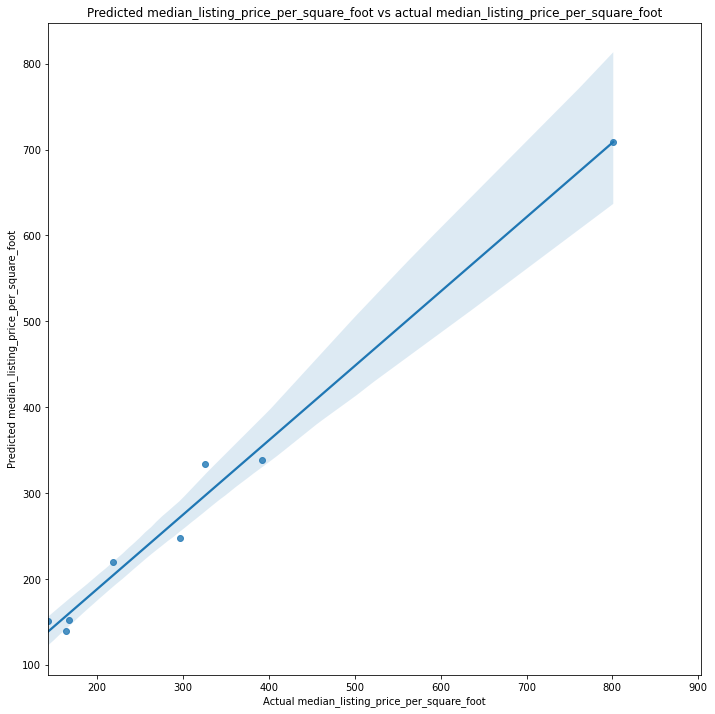

In [46]:
# Visualize predictions
_, x_test, _, y_test = train_test_split(X, y, test_size=0.3)
y_pred, zipcodes = get_model_predictions(model, x_test)
plot_evaluate(zipcodes, y_pred, y_test)

EXAMINE RESULTS

In [51]:
# Get worst zipcodes in realtor_df for model
realtor_df_slice = realtor_df_copy[["postal_code", "zip_embedding", TARGET]].sample(frac=1)[:len(realtor_df_copy) // 10]
df_errors = get_worst_zipcodes(model, realtor_df_slice)
df_errors.head()

Getting all predictions for this dataframe...


,zipcodes,predictions,actual,error
0,81224,243.633286,1025.0,781.366714
1,11101,925.160706,1339.0,413.839294
2,93546,306.596893,671.0,364.403107
3,94301,1487.043579,1781.0,293.956421
4,34216,1383.142944,1660.0,276.857056


In [54]:
# Output similar zipcodes as test_zip and their performance 
test_zip = "78750"
similar_zips = []

for zipcode in model_w2v.wv.most_similar(test_zip):
    similar_zips.append(zipcode[0])

# Get DataFrame of test_zip and similar zips
w2v_test = pd.DataFrame({
    "postal_code": [test_zip] + similar_zips
})

# Convert zips -> embeddings -> tensors
w2v_test["zip_embedding"] = w2v_test["postal_code"].apply(zip_to_embedding)

# Get predictions for current zip and context zips
predictions = get_predictions(model, w2v_test["zip_embedding"])
    
# Get actual hotness scores for current zip and context zips
actual = []
for x in w2v_test["postal_code"].values:
    score_values = realtor_df[realtor_df["postal_code"] == x][TARGET].values
    if len(score_values) == 0:
        score = None
    else:
        score = score_values[0]
    actual.append(score)
    
for index, zip in enumerate(w2v_test["postal_code"]):
    print(str(zip) + "\t Predicted " + TARGET + ": " + str(predictions[index][0][0]) 
                  + "\t Actual " + TARGET + ": " + str(actual[index]))

78750	 Predicted median_listing_price_per_square_foot: 397.93234	 Actual median_listing_price_per_square_foot: 347.0
78726	 Predicted median_listing_price_per_square_foot: 446.26718	 Actual median_listing_price_per_square_foot: None
78751	 Predicted median_listing_price_per_square_foot: 419.70676	 Actual median_listing_price_per_square_foot: None
78731	 Predicted median_listing_price_per_square_foot: 558.3519	 Actual median_listing_price_per_square_foot: 537.0
78759	 Predicted median_listing_price_per_square_foot: 431.61792	 Actual median_listing_price_per_square_foot: 404.0
78742	 Predicted median_listing_price_per_square_foot: 219.84537	 Actual median_listing_price_per_square_foot: None
78758	 Predicted median_listing_price_per_square_foot: 374.16754	 Actual median_listing_price_per_square_foot: 377.0
78753	 Predicted median_listing_price_per_square_foot: 260.38583	 Actual median_listing_price_per_square_foot: 290.0
78725	 Predicted median_listing_price_per_square_foot: 360.369	 Actu

In [49]:
def get_similarity(v1, v2):
    euc_dist = np.linalg.norm(v1 - v2)
    return 1 / (1 + euc_dist)

def calc_triplet_loss(anchor, pos, neg):
    if ((anchor not in model_w2v.wv.key_to_index.keys()) or
        (pos not in model_w2v.wv.key_to_index.keys()) or
        (neg not in model_w2v.wv.key_to_index.keys())):
        return None
    else:
        anchor_vec = model_w2v.wv[anchor]
        pos_sim = get_similarity(anchor_vec, model_w2v.wv[pos])
        neg_sim = get_similarity(anchor_vec, model_w2v.wv[neg])
        return neg_sim / pos_sim

# Fill random word vec dictionary
keys = model_w2v.wv.key_to_index.keys()
random_wordvecs = dict()
for key in keys:
    random_wordvecs[key] = np.random.rand(VECTOR_SIZE)
        
def calc_triplet_loss_baseline(anchor, pos, neg):
    if ((anchor not in random_wordvecs) or
        (pos not in random_wordvecs) or
        (neg not in random_wordvecs)):
        return None
    else:
        anchor_vec = random_wordvecs[anchor]
        pos_sim = get_similarity(anchor_vec, random_wordvecs[pos])
        neg_sim = get_similarity(anchor_vec, random_wordvecs[neg])
    return neg_sim / pos_sim

In [22]:
transactions_df_augmented = pd.read_csv("./data/evaluation_data/transactions_df_augmented.csv",
                             dtype={"zipcode": str, "transaction_zipcode": str, "negative_zipcode": str})

# Drop rows where there's no change in zipcode -> transaction zipcode
transactions_df_augmented = transactions_df_augmented[transactions_df_augmented["zipcode"] != transactions_df_augmented["transaction_zipcode"]]

transactions_df_augmented.dropna(inplace=True)
transactions_df_augmented = transactions_df_augmented[transactions_df_augmented["transaction_zipcode"] != "00000"]

# Remove transactions that didn't start and end in same DMA
transactions_df_augmented["same_dma"] = transactions_df_augmented.apply(lambda x: get_dma(x.zipcode) == get_dma(x.transaction_zipcode), axis=1)
transactions_df_augmented = transactions_df_augmented[transactions_df_augmented["same_dma"] == True]
transactions_df_augmented.drop("same_dma", axis='columns', inplace=True)

# Get triplet loss
triplet_loss = []
triplet_loss_baseline = []
for _, row in transactions_df_augmented.iterrows():
    triplet_loss.append(calc_triplet_loss(row["zipcode"], row["transaction_zipcode"], row["negative_zipcode"]))
    triplet_loss_baseline.append(calc_triplet_loss_baseline(row["zipcode"], row["transaction_zipcode"], row["negative_zipcode"]))
transactions_df_augmented.insert(5, "triplet_loss", triplet_loss)
transactions_df_augmented.insert(6, "triplet_loss_baseline", triplet_loss_baseline)

# Remove missing triplet loss
transactions_df_augmented = transactions_df_augmented[transactions_df_augmented["triplet_loss"].notnull()]
transactions_df_augmented = transactions_df_augmented.reset_index(drop=True)
# Sort by best -> worst triplet loss
transactions_df_augmented = transactions_df_augmented.sort_values(by=["triplet_loss"], ascending=False, ignore_index=True)
# Get average triplet_loss
avg_triplet_loss = np.mean(transactions_df_augmented["triplet_loss"].values)
avg_triplet_loss_baseline = np.mean(transactions_df_augmented["triplet_loss_baseline"].values)
print("Average triplet loss: " + str(avg_triplet_loss))
print("Baseline triplet loss: " + str(avg_triplet_loss_baseline))

Average triplet loss: 1.1825692300988828
Baseline triplet loss: 1.003334800267949


In [85]:
austin_df = pd.read_csv("./data/evaluation_data/transactions_df_augmented.csv",
                              usecols=["user_id", "listing_dma", "zipcode"],
                             dtype={"zipcode": str, "transaction_zipcode": str, "negative_zipcode": str})

# Get Austin transactions
austin_df = austin_df[austin_df["listing_dma"] == "Austin TX"]

# Drop repeats
austin_df = austin_df.drop_duplicates(subset='zipcode', keep="first")

# Generate ED values
austin_zipcodes = get_dma_zipcodes("Austin TX")
for zipcode in austin_zipcodes:
    if zipcode in model_w2v.wv.key_to_index.keys():
        austin_df[zipcode + "_ED"] = austin_df["zipcode"].apply(lambda x: np.linalg.norm(zip_to_embedding(zipcode) - zip_to_embedding(x)))

austin_df.to_csv("austin_euc_dist.csv", index=False)

HYPERPARAMETER TUNING

In [138]:
VECTOR_SIZE = 50
SENTENCES = agent_sentences

# Model architecture and training
model_w2v = Word2Vec(
    SENTENCES,
    vector_size=VECTOR_SIZE,
    sg=1,
    window=15,
    negative=10,
    min_count=1,
    workers=WORKERS,
    callbacks=[callback()],
    epochs=5,
    compute_loss=True,
    seed=1
)

realtor_df_tuner = realtor_df.copy()
realtor_df_tuner["zip_embedding"] = realtor_df_tuner["postal_code"].apply(zip_to_embedding)
realtor_df_tuner = realtor_df_tuner[realtor_df_tuner["zip_embedding"].notnull()]

X = realtor_df_tuner["zip_embedding"]
y = realtor_df_tuner[TARGET]

Loss after epoch 0: 8010405.5
Loss after epoch 1: 3819505.5
Loss after epoch 2: 3686325.0
Loss after epoch 3: 3320790.0
Loss after epoch 4: 3119884.0


In [ ]:
def model_build(hp):
    model = keras.Sequential()
    model.add(BatchNormalization(input_shape=[VECTOR_SIZE]))
    
    # Tune the number of layers.
    num_layers = hp.Int("num_layers", 2, 6)
    for i in range(num_layers):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=32),
                activation="relu"
            )
        )
        dropout = hp.Boolean(f"dropout_{i}") 
        if dropout:
            dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.2, max_value=0.8, step=0.1)
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
        loss="mae",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

# Kfold cross validation
class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, x, y):
        model = self.hypermodel.build(trial.hyperparameters)
        test_loss = run_KFold(model, x, y)
        self.oracle.update_trial(trial.trial_id, {'val_loss': test_loss})

cv_tuner = CVTuner(
    hypermodel=model_build,
    oracle=kt.oracles.RandomSearch(
        objective='val_loss',
        max_trials=100))

cv_tuner.search(X, y)

In [73]:
# Clearer method to get best model
best_hps = cv_tuner.get_best_hyperparameters(num_trials=1)[0]
model = cv_tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_86 (Batc (None, 50)                200       
_________________________________________________________________
dense_412 (Dense)            (None, 400)               20400     
_________________________________________________________________
dense_413 (Dense)            (None, 208)               83408     
_________________________________________________________________
dense_414 (Dense)            (None, 1)                 209       
Total params: 104,217
Trainable params: 104,117
Non-trainable params: 100
_________________________________________________________________


In [24]:
cv_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 272
dropout_0: False
units_1: 208
dropout_1: False
dropout_rate_0: 0.5000000000000001
units_2: 208
dropout_2: False
units_3: 272
dropout_3: True
units_4: 208
dropout_4: False
units_5: 432
dropout_5: False
dropout_rate_1: 0.5000000000000001
dropout_rate_2: 0.8000000000000003
dropout_rate_3: 0.30000000000000004
dropout_rate_4: 0.30000000000000004
dropout_rate_5: 0.4000000000000001
Score: 42.26133728027344
Trial summary
Hyperparameters:
num_layers: 3
units_0: 464
dropout_0: True
units_1: 496
dropout_1: True
dropout_rate_0: 0.4000000000000001
units_2: 432
dropout_2: False
units_3: 368
dropout_3: True
units_4: 496
dropout_4: True
units_5: 16
dropout_5: False
dropout_rate_1: 0.30000000000000004
dropout_rate_2: 0.4000000000000001
dropout_rate_3: 0.4000000000000001
dropout_rate_4: 0.6000000000000001
dropout_rate_5: 0.2
Score: 43.0939323425293
Trial summary
Hyperparameters:

UNIT TESTING FUNCTIONS

In [50]:
class RunTests(unittest.TestCase):
    def test_convert_four_digit_zip(self):
        self.assertEqual(convert_four_digit_zip("1111"), "01111")
        self.assertEqual(convert_four_digit_zip("0101"), "00101")
        self.assertEqual(convert_four_digit_zip("78750"), "78750")
    
    def test_zip_to_embedding(self):
        self.assertTrue(is_equal(zip_to_embedding("78750"), model_w2v.wv["78750"]))
        self.assertTrue(is_equal(zip_to_embedding("02138"), model_w2v.wv["02138"]))
        self.assertFalse(is_equal(zip_to_embedding("78750"), zip_to_embedding("02138")))
        
    def test_embeddings_to_tensors(self):
        embeddings = [zip_to_embedding("78750"), zip_to_embedding("02138"), zip_to_embedding("10007")]
        df = pd.Series(embeddings)
        tensors = embeddings_to_tensors(df)
        for i in range(len(df)):
            self.assertTrue(is_equal(tensors[i].numpy(), embeddings[i]))
            
    def test_data_to_datasets(self):
        X = pd.Series(["Joe", "Bob", "Billy", "Jane", "Emily"])
        y = pd.Series(["Male", "Male", "Male", "Female", "Female"])
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
        train_ds, val_ds, test_ds = data_to_datasets(x_train, y_train, x_val, y_val, x_test, y_test)
        groups = [(train_ds, x_train, y_train), (val_ds, x_val, y_val), (test_ds, x_test, y_test)]
        value = True
        for group in groups:
            for element in group[0]:
                names = element[0].numpy()
                values = element[1].numpy()
                for i in range(len(names)):
                    if names[i].decode("UTF-8") not in group[1].values: 
                        self.fail("shouldn't happen: " + names[i].decode("UTF-8"))
                    elif values[i].decode("UTF-8") not in group[2].values:
                        self.fail("shouldn't happen" + values[i].decode("UTF-8"))
                    else: 
                        continue
        pass
    def test_get_similarity(self):
        self.assertEqual(get_similarity(np.array([1, 2, 3]), np.array([1, 2, 3])), 1)
        self.assertTrue(get_similarity(np.array([1, 2, 3]), np.array([3, 2, 1])) < 1)
        
    def test_get_dma(self):
        self.assertEqual(get_dma(""), None)
        self.assertEqual(get_dma([]), None)
        self.assertEqual(get_dma([""]), None)
        self.assertEqual(get_dma(["2138"]), None)
        self.assertEqual(get_dma("2138"), None)
        self.assertEqual(get_dma(["78750"]), "Austin TX")
        self.assertEqual(get_dma("78750"), "Austin TX")
        self.assertEqual(get_dma("02138"), "Boston MA-Manchester NH")
        self.assertEqual(get_dma(["02138"]), "Boston MA-Manchester NH")
        self.assertEqual(get_dma(["78750", "78754", "78741"]), "Austin TX")
        
    def test_calc_triplet_loss(self):
        self.assertEqual(1, calc_triplet_loss("78750", "78750", "78750"))
        self.assertTrue(calc_triplet_loss("78750", "78750", "78704") < 1)
        self.assertTrue(calc_triplet_loss("78750", "78704", "78750") > 1)
        # Intuition guessing
        self.assertTrue(calc_triplet_loss("78750", "78754", "78719") < 1)
        self.assertTrue(calc_triplet_loss("02138", "02141", "02210") < 1)
        # Tribeca - Billionares Row - Chinatown
#         self.assertTrue(calc_triplet_loss("10007", "10019", "10002") < 1)

        
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.138s

OK
